<a href="https://colab.research.google.com/github/Senihayild/PRA3024/blob/main/GW_Assign1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment_Set 2 : Identify a loud binary black hole signal in colored, Gaussian noise. Data file is "challenge2.gwf" , the channel name is "H1:CHALLENGE2".
First, install the software and load the data in memeory.

In [113]:
! pip install -q pycbc
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

- Approximate to time of merger via plotting the Q-transform.

In [114]:
! pip install pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

! pip install -q 'gwpy==3.0.8'
from gwpy.timeseries import TimeSeries
data = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")


sampling_rate = data.sample_rate.value
duration = data.duration.value

print("Sampling Rate:", sampling_rate, "Hz")
print("Duration:", duration, "seconds")

Sampling Rate: 4096.0 Hz
Duration: 128.0 seconds


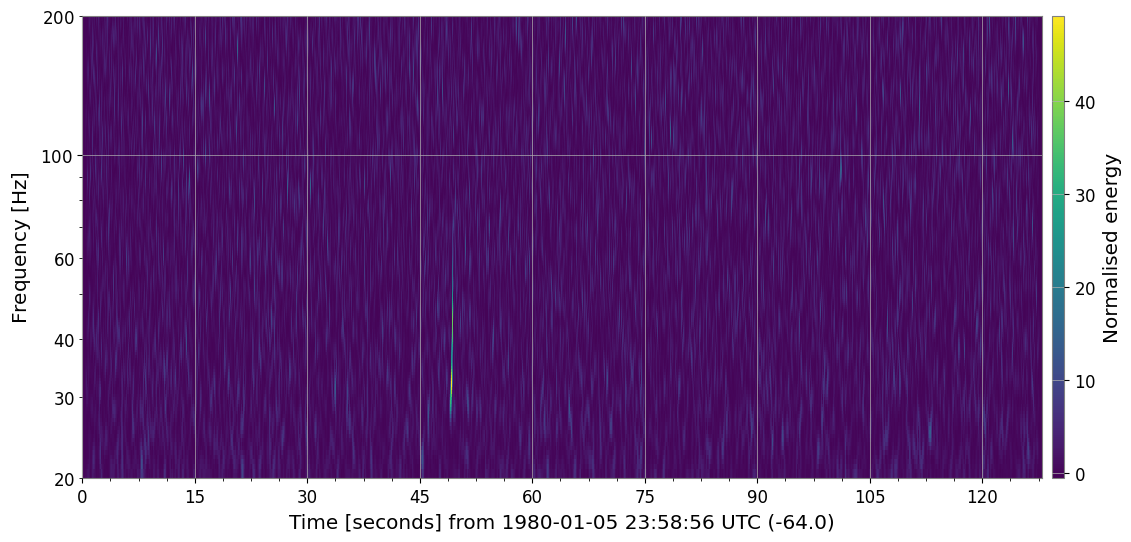

In [115]:
hq = data.q_transform(frange=(20, 200), qrange=(25, 25))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

The time of merger approximately equal to 47.5-64.0s, -16.5seconds.

- Generating a time domain template waveform using approximate SEOBNRv4 and plotting it.


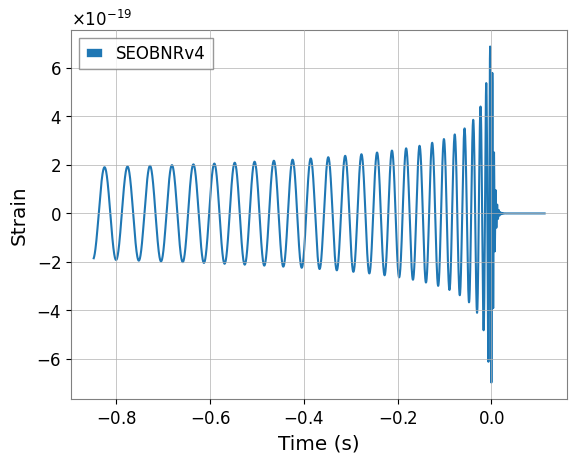

In [116]:
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform


for apx in ['SEOBNRv4']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=30,
                                 mass2=30,
                                 spin1z=0.0,
                                 delta_t=1.0/4096,
                                 delta_f=1/128,
                                 f_lower=20)

    plt.plot(hp.sample_times, hp, label=apx)

plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

- Calculate the power spectral density (PSD) and plot this on a log-log scale with the axes ranging from 20 Hz up to Nyquist frequency (2048 Hz).

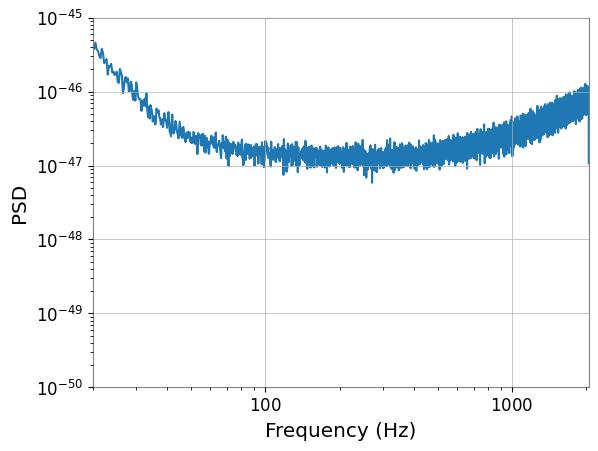

In [119]:
psd = data.psd(4)

# Plot the PSD on a log-log scale

plt.loglog(psd.frequencies, psd)
plt.xlim(20, 2048)
plt.ylim(1e-50, 1e-45)


plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.show()

In [120]:
conditioned = pycbc_strain.crop(2,2)
hp.resize(len(conditioned)) #generated waveform resized as same lenght as conditioned strain
template = hp.cyclic_time_shift(hp.start_time)

from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

- Calculating the SNR time series using template waveform and PSD.

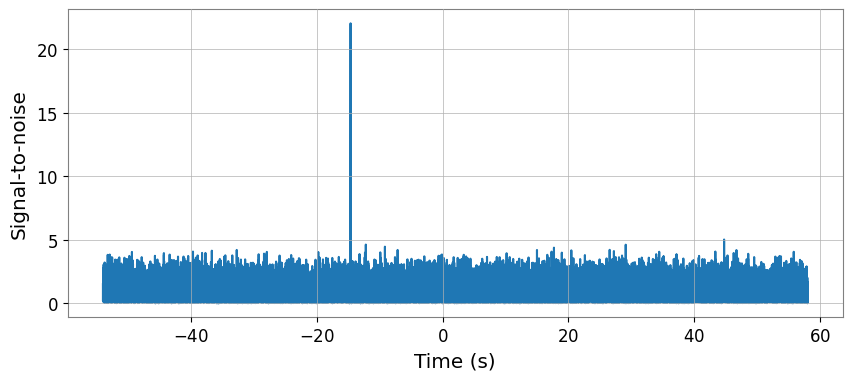

We found a signal at -14.6328125s with SNR 22.056630776919715


In [121]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for
# so short a template). A longer signal such as from a BNS, would
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# taking an abs() to maximise over the phase of the signal
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))